
# 4.6 Lab: Logistic Regression, LDA, QDA, and KNN

## 4.6.1 The Stock Market Data

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

pd.set_option('precision',4 ) # number precision for pandas

We will begin by examining some numerical and graphical summaries of the Smarket data. 
This data set consists of percentage returns for the S&P 500 stock index over 1,250 days,
from the beginning of 2001 until the end of 2005.
For each date, we have recorded the percentage returns for each of the five previous trading days,
Lag1 through Lag5. We have also recorded Volume (the number of shares traded on the previous day, in billions), 
Today (the percentage return on the date in question) and Direction (whether the market was Up or Down on this date).

In [3]:
smarket = pd.read_csv('Smarket.csv',index_col=0)
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [4]:
smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [5]:
smarket.shape

(1250, 9)

In [6]:
smarket.describe(include="all")

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
count,1250.000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250.0000,1250
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,648
mean,2003.016,0.0038,0.0039,0.0017,0.0016,0.0056,1.4783,0.0031,NaN
std,1.409,1.1363,1.1363,1.1387,1.1388,1.1476,0.3604,1.1363,NaN
min,2001.000,-4.9220,-4.9220,-4.9220,-4.9220,-4.9220,0.3561,-4.9220,NaN
25%,2002.000,-0.6395,-0.6395,-0.6400,-0.6400,-0.6400,1.2574,-0.6395,NaN
50%,2003.000,0.0390,0.0390,0.0385,0.0385,0.0385,1.4230,0.0385,NaN
75%,2004.000,0.5968,0.5968,0.5968,0.5968,0.5970,1.6417,0.5968,NaN


The corr() produces a matrix that contains all of the pairwise correlations among the predictors in a data set.

In [7]:
smarket.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.0000,0.0297,0.0306,0.0332,0.0357,0.0298,0.5390,0.0301
Lag1,0.0297,1.0000,-0.0263,-0.0108,-0.0030,-0.0057,0.0409,-0.0262
Lag2,0.0306,-0.0263,1.0000,-0.0259,-0.0109,-0.0036,-0.0434,-0.0103
Lag3,0.0332,-0.0108,-0.0259,1.0000,-0.0241,-0.0188,-0.0418,-0.0024
Lag4,0.0357,-0.0030,-0.0109,-0.0241,1.0000,-0.0271,-0.0484,-0.0069
Lag5,0.0298,-0.0057,-0.0036,-0.0188,-0.0271,1.0000,-0.0220,-0.0349
Volume,0.5390,0.0409,-0.0434,-0.0418,-0.0484,-0.0220,1.0000,0.0146
Today,0.0301,-0.0262,-0.0103,-0.0024,-0.0069,-0.0349,0.0146,1.0000


As one would expect, the correlations between the lag variables and today's returns are close to zero. In other words, 
there appears to be little correlation between today's returns and previous days' returns. The only substantial correlation
is between Year and Volume. By plotting the data we see that Volume is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

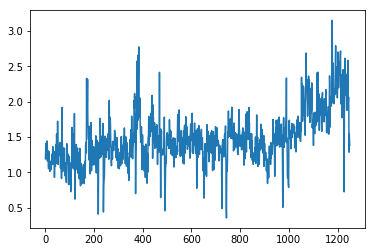

In [8]:
plt.plot(smarket.Volume);

## 4.6.2 Logistic Regression

Next, we will fit a logistic regression model in order to predict Direction using Lag1 through Lag5 and Volume.

In [9]:
# Encode the response as 0,1 for Down Up

smarket['DirCode'] = smarket['Direction'].map({'Up': 1, 'Down': 0})
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,DirCode
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1


In [10]:
logit_model= smf.logit('DirCode ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', smarket).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                DirCode   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Tue, 15 Oct 2019   Pseudo R-squ.:                0.002074
Time:                        20:08:40   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
                                        LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

The smallest p-value here is associated with Lag1. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of 0.15, the p-value is still relatively large, and so there is no clear evidence of a real association between Lag1 and Direction.

We use the params method in order to access just the coefficients for this fitted model.

In [11]:
logit_model.params

Intercept   -0.1260
Lag1        -0.0731
Lag2        -0.0423
Lag3         0.0111
Lag4         0.0094
Lag5         0.0103
Volume       0.1354
dtype: float64

The predict() function can be used to predict the probability that the market will go up, given values of the predictors.The output is of the form P (Y = 1|X).Here we have printed only the first ten probabilities. We know that these values correspond to the probability of the market going up, rather than down, because we have created a dummy variable with a 0/1 for Down/Up.

In [12]:
logit_predict=logit_model.predict()
logit_predict[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [13]:
smarket['PredictedDirection'] = logit_predict
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,DirCode,PredictedDirection
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1,0.5071
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1,0.4815
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0,0.4811
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1,0.5152
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1,0.5108


In [14]:
up = smarket.PredictedDirection >= 0.5
down = smarket.PredictedDirection < 0.5
column_name = 'PredictedDirection'
smarket.loc[up, column_name] = 'Up'
smarket.loc[down, column_name] = 'Down'
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,DirCode,PredictedDirection
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1,Down
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1,Up


In [15]:
smarket['PredictedCode'] = smarket['PredictedDirection'].map({'Up': 1, 'Down': 0})
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,DirCode,PredictedDirection,PredictedCode
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up,1,Up,1
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up,1,Down,0
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down,0,Down,0
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up,1,Up,1
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up,1,Up,1


Given these predictions, the confusion_matrix method can be used to produce a confusion matrix in order to determine how many
observations were correctly or incorrectly classified.

In [16]:
from sklearn.metrics import confusion_matrix

conf_matrix=confusion_matrix(smarket['DirCode'], smarket['PredictedCode'])
conf_matrix

array([[145, 457],
       [141, 507]], dtype=int64)

The diagonal elements of the confusion matrix indicate correct predictions,
while the off-diagonals represent incorrect predictions. Hence our model
correctly predicted that the market would go up on 507 days and that
it would go down on 145 days, for a total of 507 + 145 = 652 correct
predictions.

In [17]:
(507+145) / 1250

0.5216

In [18]:
print('The model made {} correct predictions on the TRAINING SET.'.format((conf_matrix[0,0] + conf_matrix[1,1])/logit_model.nobs))

The model made 0.5216 correct predictions on the TRAINING SET.


The mean() function can be used to compute the fraction of days for which the prediction was correct. In this case, logistic regression correctly predicted the movement of the market 52.2 % of the time.

In [19]:
np.mean(smarket['PredictedDirection'] == smarket['Direction'])

0.5216

At first glance, it appears that the logistic regression model is working a little better than random guessing. However, this result is misleading because we trained and tested the model on the same set of 1,250 observations. In other words, 100 − 52.2 = 47.8 % is the training error rate. As we have seen previously, the training error rate is often overly optimistic - it tends to underestimate the test error rate. In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model using part of the data, and then examine how well it predicts the held out data. This will yield a more realistic error rate, in the sense that in practice we will be interested in our model's performance not on the data that we used to fit the model, but rather on days in the future for which the market's movements are unknown.

To implement this strategy, we will first create a vector corresponding to the observations from 2001 through 2004. We will then use this vector to create a held out data set of observations from 2005.

In [20]:
traindf = smarket[smarket['Year'] != 2005]
testdf =smarket[smarket['Year'] == 2005]
testdf.shape

(252, 12)

We now fit a logistic regression model using only the subset of the observations that correspond to dates before 2005. We then obtain predicted probabilities of the stock market going up for each of the days in our test set - that is, for the days in 2005.

In [21]:
train_fit = smf.logit('DirCode ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', traindf).fit()
predicted_probs = train_fit.predict(testdf)

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


Notice that we have trained and tested our model on two completely separate data sets: training was performed using only the dates before 2005, and testing was performed using only the dates in 2005. Finally, we compute the predictions for 2005 and compare them to the actual movements of the market over that time period.

In [22]:
testdf['preds'] = ['Up' if p > 0.5 else 'Down' for p in predicted_probs] 
print('The model made', np.mean(testdf['preds'] == testdf['Direction']),'% correct predictions on the TEST SET.')

The model made 0.4801587301587302 % correct predictions on the TEST SET.


C:\Users\Ewa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
confusion_matrix(testdf['preds'], testdf['Direction'] )

array([[77, 97],
       [34, 44]], dtype=int64)

In [24]:
print('The model made', np.mean(testdf['preds'] != testdf['Direction']),'% incorrect predictions on the TEST SET.')

The model made 0.5198412698412699 % incorrect predictions on the TEST SET.


The != notation means not equal to, and so the last command computes the test set error rate. The results are rather disappointing: the test error rate is 52 %, which is worse than random guessing! Of course this result is not all that surprising, given that one would not generally expect to be able to use previous days' returns to predict future market performance.

We recall that the logistic regression model had very underwhelming p-values associated with all of the predictors, and that the smallest p-value, though not very small, corresponded to Lag1. Perhaps by removing the variables that appear not to be helpful in predicting Direction, we can obtain a more effective model. After all, using predictors that have no relationship with the response tends to cause a deterioration in the test error rate (since such predictors cause an increase in variance without a corresponding decrease in bias), and so removing such predictors may in turn yield an improvement. Below we have refit the logistic regression using just Lag1 and Lag2, which seemed to have the highest predictive power in the original logistic regression model.

In [25]:
train_fit = smf.logit('DirCode ~ Lag1 + Lag2', traindf).fit()
predicted_probs = train_fit.predict(testdf)
testdf['preds'] = ['Up' if p > 0.5 else 'Down' for p in predicted_probs]
print('The model made', np.mean(testdf.preds == testdf.Direction),'% correct predictions on the TEST SET.')

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3
The model made 0.5595238095238095 % correct predictions on the TEST SET.


C:\Users\Ewa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
conf_matrix=confusion_matrix(testdf['preds'], testdf['Direction'] )
conf_matrix

array([[ 35,  35],
       [ 76, 106]], dtype=int64)

In [27]:
(106+35) / (106+35+76+35)

0.5595238095238095

Now the results appear to be a little better: 56% of the daily movements have been correctly predicted. It is worth noting that in this case, a much simpler strategy of predicting that the market will increase every day will also be correct 56% of the time! Hence, in terms of overall error rate, the logistic regression method is no better than the naive approach.

In [28]:
106 / (106+76) # On the days where the market is up, we're correctly predicting 58% of the time

0.5824175824175825

In [29]:
print('On days where the prediction day is "Up" the probability the market will be "Up" is',
      conf_matrix[1,1]/(conf_matrix[1,0] + conf_matrix[1,1]))

On days where the prediction day is "Up" the probability the market will be "Up" is 0.5824175824175825


However, the confusion matrix shows that on days when logistic regression predicts an increase in the market, it has a 58% accuracy rate. This suggests a possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted. Of course one would need to investigate more carefully whether this small improvement was real or just due to random chance.

Suppose that we want to predict the returns associated with particular values of Lag1 and Lag2. In particular, we want to predict Direction on a day when Lag1 and Lag2 equal 1.2 and 1.1, respectively, and on a day when they equal 1.5 and -0.8. We do this using the predict() function.

In [30]:
pd.DataFrame({'Lag1':[1.2, 1.5], 'Lag2':[1.1,-0.8]})

,Lag1,Lag2
0,1.2,1.1
1,1.5,-0.8


In [31]:
train_fit.predict(pd.DataFrame({'Lag1':[1.2, 1.5], 'Lag2':[1.1,-0.8]}))

0    0.4791
1    0.4961
dtype: float64

## 4.6.3 Linear Discriminant Analysis

Now we will perform LDA on the Smarket data. In Python, we fit an LDA model using the LinearDiscriminantAnalysis function, which is part of the sklearn module.We fit the model using only the observations before 2005.

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [33]:
predictors = ['Lag1','Lag2']

X_train = traindf[predictors]
Y_train = traindf.DirCode

lda_model = LinearDiscriminantAnalysis()

lda_model.fit(X_train,Y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [34]:
lda_model.priors_ # Prior probabilities of groups 

array([0.49198397, 0.50801603])

The LDA output indicates that $\pi_1 = 0.492$ and $\pi_2 = 0.508$; in other words, 49.2 % of the training observations correspond to days during which the market went down.

It also provides the group means; these are the average of each predictor within each class, and are used by LDA as estimates of $\mu_k$ . These suggest that there is a tendency for the previous 2 days' returns to be negative on days when the market increases, and a tendency for the previous days' returns to be positive on days when the market declines.

In [35]:
print('Group Means: \n  Down:', lda_model.means_[0], '\n   Up:  ', lda_model.means_[1])  # first column is Lag1, second Lag2

Group Means: 
  Down: [0.04279022 0.03389409] 
   Up:   [-0.03954635 -0.03132544]


In [36]:
lda_model.scalings_ # coefficients

array([[-0.64201904],
       [-0.51352928]])

 The coefficients of linear discriminants output provides the linear combination of Lag1 and Lag2 that are used to form the LDA decision rule.
If $-0.642 \times Lag1 - 0.514 \times Lag2$ is large, then the LDA classifier will predict a market increase, and if it is small, then the LDA classifier will predict a market decline.

In [37]:
#gives you the predicted label for each sample

lda_pred_class_coded = lda_model.predict(testdf[predictors])
lda_pred_class_coded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int64)

In [38]:
lda_pred_class = ['Up' if c == 1 else 'Down' for c in lda_pred_class_coded]
testdf['lda_pred_class'] = lda_pred_class
lda_pred_class[:10]

C:\Users\Ewa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


['Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up']

In [39]:
# Compute Test Confusion Matrix

conf_matrix=confusion_matrix(testdf['lda_pred_class'], testdf['Direction'] )
conf_matrix

array([[ 35,  35],
       [ 76, 106]], dtype=int64)

In [40]:
print('The model made', np.mean(testdf['lda_pred_class'] == testdf['Direction']),'% incorrect predictions on the TEST SET.')

The model made 0.5595238095238095 % incorrect predictions on the TEST SET.


In [41]:
#the probability of each sample to belong to each class

lda_pred_posterior = lda_model.predict_proba(testdf[predictors])
lda_pred_posterior

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893],
       [0.49278766, 0.50721234],
       [0.49385615, 0.50614385],
       [0.49510156, 0.50489844],
       [0.4872861 , 0.5127139 ],
       [0.49070135, 0.50929865],
       [0.48440262, 0.51559738],
       [0.49069628, 0.50930372],
       [0.51199885, 0.48800115],
       [0.48951523, 0.51048477],
       [0.47067612, 0.52932388],
       [0.47445929, 0.52554071],
       [0.47995834, 0.52004166],
       [0.49357753, 0.50642247],
       [0.50308938, 0.49691062],
       [0.49788061, 0.50211939],
       [0.48863309, 0.51136691],
       [0.50065681, 0.49934319],
       [0.51087353, 0.48912647],
       [0.50399248, 0.49600752],
       [0.49163351, 0.50836649],
       [0.50417721, 0.49582279],
       [0.50267505, 0.49732495],
       [0.49140429, 0.50859571],
       [0.48059641, 0.51940359],
       [0.48827181, 0.51172819],
       [0.50621869, 0.49378131],
       [0.

In [42]:
# prediction summary

pd.DataFrame({'prob_0': lda_model.predict_proba(testdf[predictors])[:, 0], 
              'prob_1': lda_model.predict_proba(testdf[predictors])[:, 1], 
              'pred_class': lda_model.predict(testdf[predictors])}, 
             columns=['prob_0', 'prob_1', 'pred_class'])

,prob_0,prob_1,pred_class
0,0.4902,0.5098,1
1,0.4792,0.5208,1
2,0.4668,0.5332,1
3,0.4740,0.5260,1
4,0.4928,0.5072,1
5,0.4939,0.5061,1
6,0.4951,0.5049,1
7,0.4873,0.5127,1
8,0.4907,0.5093,1
9,0.4844,0.5156,1


Applying a 50 % threshold to the posterior probabilities allows us to recreate the predictions contained in lda_pred_class.

In [43]:
np.sum(lda_pred_posterior[:,0] >= 0.5)

70

In [44]:
np.sum(lda_pred_posterior[:,1] >= 0.5)

182

Notice that the posterior probability output by the model corresponds to the probability that the market will decrease:

In [45]:
lda_pred_posterior[:20,0]

array([0.49017925, 0.4792185 , 0.46681848, 0.47400107, 0.49278766,
       0.49385615, 0.49510156, 0.4872861 , 0.49070135, 0.48440262,
       0.49069628, 0.51199885, 0.48951523, 0.47067612, 0.47445929,
       0.47995834, 0.49357753, 0.50308938, 0.49788061, 0.48863309])

In [46]:
testdf.lda_pred_class[:20]

999       Up
1000      Up
1001      Up
1002      Up
1003      Up
1004      Up
1005      Up
1006      Up
1007      Up
1008      Up
1009      Up
1010    Down
1011      Up
1012      Up
1013      Up
1014      Up
1015      Up
1016    Down
1017      Up
1018      Up
Name: lda_pred_class, dtype: object

If we wanted to use a posterior probability threshold other than 50 % in order to make predictions, then we could easily do so. For instance, suppose that we wish to predict a market decrease only if we are very certain that the market will indeed decrease on that day-say, if the posterior probability is at least 90 %.

In [47]:
np.sum(lda_pred_posterior[:,0] >= 0.9)

0

No days in 2005 meet that threshold! In fact, the greatest posterior probability of decrease in all of 2005 was 52.02 %

In [48]:
np.max(lda_pred_posterior[:,0])

0.5202349505356155

## <font color='red'>4.6.4 Quadratic Discriminant Analysis</font>

We will now fit a QDA model to the Smarket data. QDA is implemented in the sklearn module. The syntax is identical to that of lda().

In [49]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train,Y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [50]:
qda_model.priors_ # Prior probabilities of groups 

array([0.49198397, 0.50801603])

In [51]:
print('Group Means: \n  Down:', qda_model.means_[0], '\n   Up:  ', qda_model.means_[1])  # first column is Lag1, second Lag2

Group Means: 
  Down: [0.04279022 0.03389409] 
   Up:   [-0.03954635 -0.03132544]


The output contains the group means. But it does not contain the coefficients of the linear discriminants, because the QDA classifier involves a quadratic, rather than a linear, function of the predictors. The predict() function works in exactly the same fashion as for LDA.

In [52]:
#gives you the predicted label for each sample

qda_pred_class_coded = qda_model.predict(testdf[predictors])
qda_pred_class_coded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [53]:
qda_pred_class = ['Up' if c == 1 else 'Down' for c in qda_pred_class_coded]
testdf['qda_pred_class'] = qda_pred_class

C:\Users\Ewa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [54]:
# Compute Test Confusion Matrix

conf_matrix=confusion_matrix(testdf['qda_pred_class'], testdf['Direction'] )
conf_matrix

array([[ 30,  20],
       [ 81, 121]], dtype=int64)

In [55]:
print('The model made', np.mean(testdf['qda_pred_class'] == testdf['Direction']),'% incorrect predictions on the TEST SET.')

The model made 0.5992063492063492 % incorrect predictions on the TEST SET.


Interestingly, the QDA predictions are accurate almost 60% of the time,
even though the 2005 data was not used to fit the model. This level of accuracy
is quite impressive for stock market data, which is known to be quite
hard to model accurately. This suggests that the quadratic form assumed
by QDA may capture the true relationship more accurately than the linear
forms assumed by LDA and logistic regression.

## <font color='red'>4.6.5 K-Nearest Neighbors</font>

We will now perform KNN using the KNeighborsClassifier() function, which is part of the sklearn module.To fit the model we need to pass a matrix of the predictors, and a vector with the corresponding class labels.

In [56]:
from sklearn.neighbors import KNeighborsClassifier as KNNC

# Build a KNN classifier
knn_1 = KNNC(n_neighbors=1)
knn_1.fit(X_train, traindf.Direction)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='uniform')

In [57]:
knn_1_pred = knn_1.predict(testdf[predictors])
knn_1_pred

array(['Up', 'Down', 'Up', 'Up', 'Up', 'Down', 'Down', 'Down', 'Down',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up',
       'Up', 'Down', 'Down', 'Down', 'Down', 'Down', 'Up', 'Up', 'Up',
       'Down', 'Up', 'Up', 'Down', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up',
       'Down', 'Up', 'Up', 'Up', 'Down', 'Down', 'Down', 'Down', 'Up',
       'Down', 'Up', 'Up', 'Down', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up',
       'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Down', 'Down',
       'Up', 'Up', 'Up', 'Up', 'Down', 'Up', 'Down', 'Down', 'Down', 'Up',
       'Up', 'Up', 'Down', 'Up', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up',
       'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Down', 'Down', 'Up', 'Up',
       'Up', 'Up', 'Down', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up', 'Down',
       'Down', 'Down', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Up',
       'Up', 'Down', 'Up', 'Up', 'Up', 'Down', 'Up', 'Down', 'Down', 'Up',
       'Up', 'Down', 'Down', 'Down', 'Down', 'U

In [58]:
print('The model made', np.mean(knn_1_pred == testdf['Direction']),'% incorrect predictions on the TEST SET.')

The model made 0.5 % incorrect predictions on the TEST SET.


In [59]:
# Compute Test Confusion Matrix

conf_matrix=confusion_matrix(knn_1_pred, testdf['Direction'] )
conf_matrix

array([[43, 58],
       [68, 83]], dtype=int64)

The results using K = 1 are not very good, since only 50 % of the observations are correctly predicted. Of course, it may be that K = 1 results in an overly flexible fit to the data. Below, we repeat the analysis using K = 3.

In [60]:
knn_3 = KNNC(n_neighbors=3)
knn_3.fit(X_train, traindf.Direction)
knn_3_pred = knn_3.predict(testdf[predictors])
print('The model made', np.mean(knn_3_pred == testdf['Direction']),'% incorrect predictions on the TEST SET.')

The model made 0.5317460317460317 % incorrect predictions on the TEST SET.


In [61]:
conf_matrix=confusion_matrix(knn_3_pred, testdf['Direction'] )
conf_matrix

array([[48, 55],
       [63, 86]], dtype=int64)

The results have improved slightly. But increasing K further turns out to provide no further improvements. It appears that for this data, QDA provides the best results of the methods that we have examined so far.

## <font color='red'>4.6.6 An Application to Caravan Insurance Data</font>

Finally, we will apply the KNN approach to the Caravan data set. This data set includes 85 predictors that measure demographic characteristics for 5822 individuals. The response variable is Purchase, which indicates whether or not a given individual purchases a caravan insurance policy. In this data set, only 6% of people purchased caravan insurance.

In [62]:
# Load the caravan insurance data
caravan= pd.read_csv('caravan_data', index_col=0)
caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
3,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
4,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
5,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [63]:
caravan.shape

(5822, 86)

In [64]:
caravan["Purchase"].value_counts()


No     5474
Yes     348
Name: Purchase, dtype: int64

In [65]:
348/5822 # only 6% of people purchased caravan insurance

0.05977327378907592

Because the KNN classifier predicts the class of a given test observation by
identifying the observations that are nearest to it, the scale of the variables
matters. Any variables that are on a large scale will have a much larger
effect on the distance between the observations, and hence on the KNN
classifier, than variables that are on a small scale.

A good way to handle this problem is to standardize the data so that all variables are given a mean of zero and a standard deviation of one. Then all variables will be on a comparable scale. In standardizing the data, we exclude column 86, because that is the qualitative Purchase variable.

In [67]:
from sklearn.preprocessing import scale

standardized_X = scale(caravan.iloc[:,0:85], axis=0)

# check that X[:,1] is now standardized
print('mean =', np.mean(standardized_X[:,1]), 'variance = ', np.var(standardized_X[:,1]))

mean = -1.6140377328112892e-16 variance =  1.0


C:\Users\Ewa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  This is separate from the ipykernel package so we can avoid doing imports until


Now every column of standardized_X has a standard deviation of one and a mean of zero.

We now split the observations into a test set, containing the first 1,000 observations, and a training set, containing the remaining observations. We fit a KNN model on the training data using K = 1, and evaluate its performance on the test data.

In [68]:
Y = caravan.Purchase.values

X_train = standardized_X[1000:]
X_test = standardized_X[:1000]
Y_train = Y[1000:]
Y_test = Y[:1000]

knn1 = KNNC(n_neighbors=1)
knn1.fit(X_train, Y_train)
knn1_pred = knn1.predict(X_test)

error_rate = np.mean(knn1_pred != Y_test)

print('The error rate for k={} is {:.3f} %'.format(1, 100*error_rate))
print('There are {} % custumors who bought insurance on the test set.'.format(np.mean(Y_test == 'Yes')))

The error rate for k=1 is 11.800 %
There are 0.059 % custumors who bought insurance on the test set.


The KNN error rate on the
1,000 test observations is just under 12%. At first glance, this may appear
to be fairly good. However, since only 6% of customers purchased
insurance, we could get the error rate down to 6% by always predicting No
regardless of the values of the predictors!

Suppose that there is some non-trivial cost to trying to sell insurance
to a given individual. For instance, perhaps a salesperson must visit each
potential customer. If the company tries to sell insurance to a random
selection of customers, then the success rate will be only 6%, which may
be far too low given the costs involved. Instead, the company would like
to try to sell insurance only to customers who are likely to buy it. So the
overall error rate is not of interest. Instead, the fraction of individuals that
are correctly predicted to buy insurance is of interest.

It turns out that KNN with K = 1 does far better than random guessing
among the customers that are predicted to buy insurance. Among 77 such
customers, 9, or 11.7%, actually do purchase insurance. This is double the
rate that one would obtain from random guessing.

In [69]:
conf_matrix=confusion_matrix(knn1_pred, Y_test ) #  knn1.pred No Yes
                                                         # No 873 50
                                                         # Yes 68 9
conf_matrix

array([[873,  50],
       [ 68,   9]], dtype=int64)

In [70]:
9/(68+9)

0.11688311688311688

In [71]:
print("The true positive rate on the test set: {}".format(100*(conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[1,0]))))

The true positive rate on the test set: 11.688311688311687


Using K = 3, the success rate increases to 20 %, and with K = 5 the rate is 26.7 %. This is over four times the rate that results from random guessing. It appears that KNN is finding some real patterns in a difficult data set!

In [72]:
knn3 = KNNC(n_neighbors=3)
knn3.fit(X_train, Y_train)
knn3_pred = knn3.predict(X_test)

error_rate = np.mean(knn3_pred != Y_test)
print('The error rate for k={} is {:.3f} %'.format(3, 100*error_rate))

conf_matrix=confusion_matrix(knn3_pred, Y_test )
print("The true positive rate on the test set: {}".format(100*(conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[1,0]))))


The error rate for k=3 is 7.400 %
The true positive rate on the test set: 20.0


In [73]:
knn5 = KNNC(n_neighbors=5)
knn5.fit(X_train, Y_train)
knn5_pred = knn5.predict(X_test)

error_rate = np.mean(knn5_pred != Y_test)
print('The error rate for k={} is {:.3f} %'.format(5, 100*error_rate))

conf_matrix=confusion_matrix(knn5_pred, Y_test )
print("The true positive rate on the test set: {}".format(100*(conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[1,0]))))


The error rate for k=5 is 6.600 %
The true positive rate on the test set: 26.666666666666668


As a comparison, we can also fit a logistic regression model to the data. If we use 0.5 as the predicted probability cut-off for the classifier, then we have a problem: only seven of the test observations are predicted to purchase insurance. Even worse, we are wrong about all of these! However, we are not required to use a cut-off of 0.5. If we instead predict a purchase any time the predicted probability of purchase exceeds 0.25, we get much better results: we predict that 33 people will purchase insurance, and we are correct for about 33 % of these people. This is over five times better than random guessing!

In [76]:
predictors = caravan.columns.tolist()[:-1]

Y_train_coded = [0 if d == 'No' else 1 for d in Y_train]

X_train2 = sm.add_constant(X_train) # Add a column of ones to an array.

logit_model = sm.Logit(Y_train_coded, X_train2).fit()

X_test2 = sm.add_constant(X_test, has_constant='add')

logit_probs = logit_model.predict(X_test2)

logit_pred = pd.Series(['Yes' if p > 0.5 else 'No' for p in logit_probs])

conf_matrix=confusion_matrix(logit_pred, Y_test )
conf_matrix

         Current function value: 0.192013
         Iterations: 35


C:\Users\Ewa\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


array([[934,  59],
       [  7,   0]], dtype=int64)

In [77]:
logit_pred = pd.Series(['Yes' if p > 0.25 else 'No' for p in logit_probs])
conf_matrix=confusion_matrix(logit_pred, Y_test )
conf_matrix

array([[919,  48],
       [ 22,  11]], dtype=int64)

In [78]:
print("The true positive rate on the test set: {}".format(100*(conf_matrix[1,1]/(conf_matrix[1,1] + conf_matrix[1,0]))))


The true positive rate on the test set: 33.33333333333333
